Information about notebook:
*   Using yolov4 from https://github.com/AlexeyAB/darknet
*   Forked the repo and added configuration files for custom training












In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os

os.chdir('/content/drive/My Drive/yolo')

In [ ]:
!git clone https://github.com/trolommonm/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 13658 (delta 2), reused 1 (delta 0), pack-reused 13652
Receiving objects: 100% (13658/13658), 12.24 MiB | 9.29 MiB/s, done.
Resolving deltas: 100% (9316/9316), done.
Checking out files: 100% (2004/2004), done.


In [ ]:
os.chdir('darknet/data')
!mkdir obj
os.chdir('obj')

In [ ]:
#download data, configure based on competition
!kaggle competitions download til2020
!unzip \*.zip

In [ ]:
# create annotations for each image, yolo requires each image to have a txt file 
import pandas as pd
import json

train_json = open('train.json')
train_dict = json.load(train_json)
train_annotations_list = train_dict['annotations']

import os 
from PIL import Image

# the given bbox is (left, top, width, height)
# yolo requires this format <object-class> <x> <y> <width> <height>
# x and y is center
def convertToYoloBBox(annotation_bbox, img_size):
  left = annotation_bbox[0]
  top = annotation_bbox[1]
  width = annotation_bbox[2]
  height = annotation_bbox[3]
  img_width, img_height = img_size

  yolo_x = left + width/2
  yolo_x = yolo_x/img_width
  yolo_y = top + height/2
  yolo_y = yolo_y/img_height

  yolo_w = width/img_width
  yolo_h = height/img_height
  return yolo_x, yolo_y, yolo_w, yolo_h

def getTrainAnnotations(image_id):
  return [annotation for annotation in train_annotations_list if annotation['image_id'] == image_id]

path_to_train = 'train/train'
for index, image in enumerate(os.listdir(path_to_train)):
  print(f'Index: {index} image: {image}')
  image_id = int(os.path.splitext(image)[0])
  img_pil = Image.open(os.path.join(path_to_train, image))
  annotations = getTrainAnnotations(image_id)
  if annotations:
    for annotation in annotations:
      yolo_bbox = convertToYoloBBox(annotation['bbox'], img_pil.size)
      with open(os.path.join(path_to_train, f'{image_id}.txt'), 'a') as file:
        category_id = annotation['category_id'] - 1
        file.write(f'{category_id} {yolo_bbox[0]} {yolo_bbox[1]} {yolo_bbox[2]} {yolo_bbox[3]}\n')
        file.close()
  else:
    with open(os.path.join(path_to_train, f'{image_id}.txt'), 'w') as file:
      file.close()

In [ ]:
val_json = open('val.json')
val_dict = json.load(val_json)
val_annotations_list = val_dict['annotations']

def getValAnnotations(image_id):
  return [annotation for annotation in val_annotations_list if annotation['image_id'] == image_id]

path_to_val = 'val/val'
for index, image in enumerate(os.listdir(path_to_val)):
  print(f'Index: {index} image: {image}')
  image_id = int(os.path.splitext(image)[0])
  img_pil = Image.open(os.path.join(path_to_val, image))
  annotations = getValAnnotations(image_id)
  if annotations:
    for annotation in annotations:
      yolo_bbox = convertToYoloBBox(annotation['bbox'], img_pil.size)
      with open(os.path.join(path_to_val, f'{image_id}.txt'), 'a') as file:
        category_id = annotation['category_id'] - 1
        file.write(f'{category_id} {yolo_bbox[0]} {yolo_bbox[1]} {yolo_bbox[2]} {yolo_bbox[3]}\n')
        file.close()
  else:
    with open(os.path.join(path_to_val, f'{image_id}.txt'), 'w') as file:
      file.close()

In [ ]:
os.chdir('..')

In [ ]:
train_base = 'data/obj/train/train'
for image in train_dict['images']:
  with open('train.txt', 'a') as file:
    path = os.path.join(train_base, image['file_name'])
    file.write(f'{path}\n')
    file.close()

val_base = 'data/obj/val/val'
for image in val_dict['images']:
  with open('test.txt', 'a') as file:
    path = os.path.join(val_base, image['file_name'])
    file.write(f'{path}\n')
    file.close()

In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
# make darknet (build)
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:910:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1391:14: warning: unused variable ‘buff’ [-Wunused-variable]
         char buff[100];
              ^~~~
./src/image_opencv.cpp:1367:9: warning: unused variable ‘it_tb_res’ [-W

In [ ]:
!chmod +x darknet

In [ ]:
!curl -O https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   626  100   626    0     0   2782      0 --:--:-- --:--:-- --:--:--  2782


In [ ]:
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg yolov4.conv.137 -dont_show -map

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 Prepare additional network for mAP calculation...
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 64, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 ^C


In [ ]:
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg '/content/drive/My Drive/yolo/darknet/backup/yolov4-obj_last.weights' -dont_show -map

Streaming output truncated to the last 5000 lines.
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 150 Avg (IOU: 0.702552, GIOU: 0.688304), Class: 0.881735, Obj: 0.130889, No Obj: 0.000726, .5R: 1.000000, .75R: 0.000000, count: 1, class_loss = 0.918529, iou_loss = 0.517161, total_loss = 1.435691 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 161 Avg (IOU: 0.760722, GIOU: 0.746902), Class: 0.792852, Obj: 0.336262, No Obj: 0.004379, .5R: 1.000000, .75R: 1.000000, count: 2, class_loss = 1.619386, iou_loss = 0.539043, total_loss = 2.158429 
 total_bbox = 114616, rewritten_bbox = 5.753123 % 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 139 Avg (IOU: 0.000000, GIOU: 0.000000), Class: 0.000000, Obj: 0.000000, No Obj: 0.000002, .5R: 0.000000, .75R: 0.000000, count: 1, class_loss = 0.000001, iou_loss = 0.000000, total_loss = 0.000001 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 150 Avg (IOU: 0.649591, GIOU: 0.649591), Class: 0.736865, Obj: 0.000046, No O

In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
!chmod +x darknet
!./darknet detector test 'data/obj.data' 'cfg/yolov4-obj.cfg' '/content/drive/My Drive/yolo/darknet/backup/yolov4-obj_best.weights' '/content/drive/My Drive/yolo/darknet/data/obj/val/10000.jpg' -thresh 0.1
imShow('predictions.jpg')

chmod: cannot access 'darknet': No such file or directory
/bin/bash: ./darknet: No such file or directory


NameError: ignored

In [ ]:
!./darknet detector map data/obj.data 'cfg/yolov4-obj.cfg' '/content/drive/My Drive/yolo/darknet/backup/yolov4-obj_64mAP.weights'

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 64, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x 

In [ ]:
!ls

3rdparty   chart_yolov4-obj.png    image_yolov2.sh	  predictions.jpg
backup	   cmake		   image_yolov3.sh	  README.md
bad.list   CMakeLists.txt	   include		  results
build	   darknet		   json_mjpeg_streams.sh  scripts
build.ps1  DarknetConfig.cmake.in  LICENSE		  src
build.sh   darknet.py		   Makefile		  video_v2.sh
cfg	   darknet_video.py	   net_cam_v3.sh	  video_yolov3.sh
chart.png  data			   obj			  yolov4.conv.137


In [ ]:
from darknet import performDetect

In [ ]:
import json 

interim_file = '/content/drive/My Drive/yolo/darknet/data/obj/CV_interim_evaluation.json'
interim_file = open(interim_file)
interim_list = json.load(interim_file)
interim_list = interim_list['images']
len(interim_list)

1000

In [ ]:


category = {
    "tops": 1,
    "trousers": 2,
    "outerwear": 3,
    "dresses": 4,
    "skirts": 5,
}

submission = []

for interim_image in interim_list:
  filename = interim_image['file_name']
  filename = f'/content/drive/My Drive/yolo/darknet/data/obj/CV_interim_images/{filename}'
  print(filename)
  preds = performDetect(imagePath=filename, thresh= 0.01, configPath = "./cfg/yolov4-obj.cfg", weightPath = "./backup/yolov4-obj_best.weights", metaPath= "./data/obj.data", showImage= False, makeImageOnly = False, initOnly= False)
  for pred in preds:
    category_id = category[pred[0]]
    image_id = interim_image['id']
    score = pred[1]
    bbox = pred[2]
    x = bbox[0] - 0.5 * bbox[2]
    y = bbox[1] - 0.5 * bbox[3] 
    width = bbox[2]
    height = bbox[3]

    tmpDict = {
        "category_id": category_id,
        "image_id": image_id,
        "score": score,
        "bbox": [x, y, width, height]
    }

    submission.append(tmpDict)




/content/drive/My Drive/yolo/darknet/data/obj/CV_interim_images/6964.jpg
/content/drive/My Drive/yolo/darknet/data/obj/CV_interim_images/9753.jpg
/content/drive/My Drive/yolo/darknet/data/obj/CV_interim_images/14392.jpg
/content/drive/My Drive/yolo/darknet/data/obj/CV_interim_images/12249.jpg
/content/drive/My Drive/yolo/darknet/data/obj/CV_interim_images/3191.jpg
/content/drive/My Drive/yolo/darknet/data/obj/CV_interim_images/16159.jpg
/content/drive/My Drive/yolo/darknet/data/obj/CV_interim_images/9163.jpg
/content/drive/My Drive/yolo/darknet/data/obj/CV_interim_images/9880.jpg
/content/drive/My Drive/yolo/darknet/data/obj/CV_interim_images/915.jpg
/content/drive/My Drive/yolo/darknet/data/obj/CV_interim_images/8957.jpg
/content/drive/My Drive/yolo/darknet/data/obj/CV_interim_images/11600.jpg
/content/drive/My Drive/yolo/darknet/data/obj/CV_interim_images/10690.jpg
/content/drive/My Drive/yolo/darknet/data/obj/CV_interim_images/12625.jpg
/content/drive/My Drive/yolo/darknet/data/obj/

In [ ]:
!pwd

/content/drive/My Drive/yolo/darknet


In [ ]:
with open('submission.json', 'w') as file:
  file.write(json.dumps(submission))
  file.close()

In [ ]:
pred = performDetect(imagePath="/content/drive/My Drive/yolo/darknet/data/obj/val/988.jpg", thresh= 0.10, configPath = "./cfg/yolov4-obj.cfg", weightPath = "./backup/yolov4-obj_best.weights", metaPath= "./data/obj.data", showImage= False, makeImageOnly = False, initOnly= False)
pred

[('dresses',
  0.6069837212562561,
  (552.1376342773438,
   818.627197265625,
   255.29176330566406,
   471.2033386230469)),
 ('outerwear',
  0.5258070230484009,
  (550.4168701171875, 714.388916015625, 311.1002197265625, 356.6095886230469))]

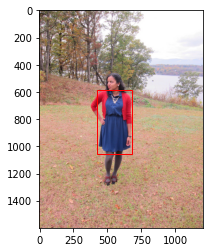

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

i = pred[0]
im = Image.open('/content/drive/My Drive/yolo/darknet/data/obj/val/988.jpg')
im = np.array(im, dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

bbox = i[2]
x = bbox[0] - 0.5 * bbox[2]
y = bbox[1] - 0.5 * bbox[3]

# Create a Rectangle patch
rect = patches.Rectangle((x,y), bbox[2], bbox[3],linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [ ]:
%cd '/content/drive/My Drive/yolo/darknet/data/obj/final_images'

/content/drive/.shortcut-targets-by-id/10tLM93KWrfeBeQMiOmZIyTiJ78Hkaajk/final_images


In [ ]:
!unzip CV_final_images.zip

Archive:  CV_final_images.zip
  inflating: CV_final_images/10015.jpg  
  inflating: CV_final_images/10030.jpg  
  inflating: CV_final_images/10038.jpg  
  inflating: CV_final_images/1004.jpg  
  inflating: CV_final_images/10044.jpg  
  inflating: CV_final_images/10055.jpg  
  inflating: CV_final_images/10057.jpg  
  inflating: CV_final_images/10060.jpg  
  inflating: CV_final_images/10067.jpg  
  inflating: CV_final_images/10068.jpg  
  inflating: CV_final_images/10073.jpg  
  inflating: CV_final_images/10077.jpg  
  inflating: CV_final_images/1008.jpg  
  inflating: CV_final_images/10085.jpg  
  inflating: CV_final_images/10087.jpg  
  inflating: CV_final_images/10092.jpg  
  inflating: CV_final_images/10104.jpg  
  inflating: CV_final_images/10105.jpg  
  inflating: CV_final_images/1011.jpg  
  inflating: CV_final_images/10127.jpg  
  inflating: CV_final_images/10129.jpg  
  inflating: CV_final_images/10131.jpg  
  inflating: CV_final_images/10133.jpg  
  inflating: CV_final_images/1

In [ ]:
import json 

final_file = '/content/drive/My Drive/yolo/darknet/data/obj/final_images/CV_final_evaluation.json'
final_file = open(final_file)
final_list = json.load(final_file)
final_list = final_list['images']
len(final_list)

1972

In [ ]:
%cd '/content/drive/My Drive/yolo/darknet'

/content/drive/My Drive/yolo/darknet


In [ ]:
from darknet import performDetect

In [ ]:


category = {
    "tops": 1,
    "trousers": 2,
    "outerwear": 3,
    "dresses": 4,
    "skirts": 5,
}

submission_final = []

for final_image in final_list:
  filename = final_image['file_name']
  filename = f'/content/drive/My Drive/yolo/darknet/data/obj/final_images/CV_final_images/{filename}'
  print(filename)
  preds = performDetect(imagePath=filename, thresh= 0.01, configPath = "./cfg/yolov4-obj.cfg", weightPath = "/content/drive/My Drive/yolo/darknet/backup/yolov4-obj_64mAP.weights", metaPath= "./data/obj.data", showImage= False, makeImageOnly = False, initOnly= False)
  for pred in preds:
    category_id = category[pred[0]]
    image_id = final_image['id']
    score = pred[1]
    bbox = pred[2]
    x = bbox[0] - 0.5 * bbox[2]
    y = bbox[1] - 0.5 * bbox[3] 
    width = bbox[2]
    height = bbox[3]

    tmpDict = {
        "category_id": category_id,
        "image_id": image_id,
        "score": score,
        "bbox": [x, y, width, height]
    }

    submission_final.append(tmpDict)




/content/drive/My Drive/yolo/darknet/data/obj/final_images/CV_final_images/10044.jpg
/content/drive/My Drive/yolo/darknet/data/obj/final_images/CV_final_images/10055.jpg
/content/drive/My Drive/yolo/darknet/data/obj/final_images/CV_final_images/10057.jpg
/content/drive/My Drive/yolo/darknet/data/obj/final_images/CV_final_images/10085.jpg
/content/drive/My Drive/yolo/darknet/data/obj/final_images/CV_final_images/10127.jpg
/content/drive/My Drive/yolo/darknet/data/obj/final_images/CV_final_images/10131.jpg
/content/drive/My Drive/yolo/darknet/data/obj/final_images/CV_final_images/10138.jpg
/content/drive/My Drive/yolo/darknet/data/obj/final_images/CV_final_images/10151.jpg
/content/drive/My Drive/yolo/darknet/data/obj/final_images/CV_final_images/10154.jpg
/content/drive/My Drive/yolo/darknet/data/obj/final_images/CV_final_images/10163.jpg
/content/drive/My Drive/yolo/darknet/data/obj/final_images/CV_final_images/10187.jpg
/content/drive/My Drive/yolo/darknet/data/obj/final_images/CV_fin

In [ ]:
with open('submission_final.json', 'w') as file:
  file.write(json.dumps(submission_final))
  file.close()

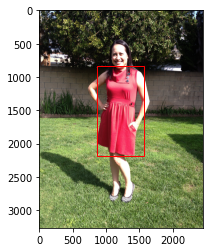

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

filename = '/content/drive/My Drive/yolo/darknet/data/obj/final_images/CV_final_images/9632.jpg'
preds = performDetect(imagePath=filename, thresh= 0.01, configPath = "./cfg/yolov4-obj.cfg", weightPath = "/content/drive/My Drive/yolo/darknet/backup/yolov4-obj_64mAP.weights", metaPath= "./data/obj.data", showImage= False, makeImageOnly = False, initOnly= False)
i = preds[0]
im = Image.open(filename)
im = np.array(im, dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

bbox = i[2]
x = bbox[0] - 0.5 * bbox[2]
y = bbox[1] - 0.5 * bbox[3]

# Create a Rectangle patch
rect = patches.Rectangle((x,y), bbox[2], bbox[3],linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()